In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
#external files
from preprocessing import FileIO
# from weaviate_interface import WeaviateClient
from weaviate_with_reranking import WeaviateClient
from retrieval_evaluation import calc_hit_rate_scores, calc_mrr_scores
from reranker import ReRanker

#external libraries
from llama_index.finetuning import EmbeddingQAFinetuneDataset
import plotly.express as px

#standard library imports
from typing import List, Any, Dict, Tuple, Union
import time
import os

# utilities
from tqdm import tqdm
from rich import print
from dotenv import load_dotenv
env = load_dotenv('./.env', override=True)

### Load QA dataset

In [70]:
golden_dataset = EmbeddingQAFinetuneDataset.from_json("./data/golden_dataset.json")

### Instantiate Weaviate client and set Class name

In [71]:
client = WeaviateClient(os.environ['WEAVIATE_API_KEY'], os.environ['WEAVIATE_ENDPOINT'])
class_name = 'Impact_theory_minilm_256'

#check if WCS instance is live and ready
client.is_live(), client.is_ready()

(True, True)

### Evaluate Retrieval methods

In [72]:
def execute_evaluation( dataset: EmbeddingQAFinetuneDataset, 
                        class_name: str, 
                        retriever: WeaviateClient,
                        reranker: ReRanker=None,
                        alpha: float=0.5,
                        retrieve_limit: int=5,
                        results_top_k: int=5,
                        rerank_top_k: int=5,
                        chunk_size: int=256,
                        display_properties: List[str]=['doc_id', 'content']
                        ) -> Tuple[int, int, int]:

    if results_top_k > retrieve_limit:  # we don't want to retrieve less results than the top_k that we want to see returned
        retrieve_limit = results_top_k
        
    reranker_name = reranker.model_name if reranker else "None"
    
    results_dict = {'n':retrieve_limit, 
                    'top_k': results_top_k,
                    'alpha': alpha,
                    'Retriever': retriever.model_name_or_path, 
                    'Ranker': reranker_name,
                    'chunk_size': chunk_size,
                    'kw_hit_rate': 0,
                    'kw_mrr': 0,
                    'vector_hit_rate': 0,
                    'vector_mrr': 0,
                    'hybrid_hit_rate':0,
                    'hybrid_mrr': 0,
                    'total_misses': 0,
                    'total_questions':0
                    }
    if reranker:
        results_dict['rerank_top_k'] = rerank_top_k  # have to build the results_dict before we can add this information
        
    start = time.perf_counter()
    for query_id, q in tqdm(dataset.queries.items(), 'Queries'):
        results_dict['total_questions'] += 1
        
        #make Keyword, Vector, and Hybrid calls to Weaviate host
        try:
            kw_response = retriever.keyword_search(request=q, class_name=class_name, limit=retrieve_limit, display_properties=display_properties)
            vector_response = retriever.vector_search(request=q, class_name=class_name, limit=retrieve_limit, display_properties=display_properties)
            hybrid_response = retriever._hybrid_search(request=q, class_name=class_name, alpha=alpha, limit=retrieve_limit, display_properties=display_properties)           
    
            #rerank returned responses if reranker is provided
            if reranker:
                kw_response = reranker.rerank(kw_response, q, top_k=rerank_top_k)
                vector_response = reranker.rerank(vector_response, q, top_k=rerank_top_k)
                hybrid_response = reranker.rerank(hybrid_response, q, top_k=rerank_top_k)
            
            #collect doc_ids to check for document matches (include only results_top_k)
            kw_doc_ids = {result['doc_id']:i for i, result in enumerate(kw_response[:results_top_k], 1)}
            vector_doc_ids = {result['doc_id']:i for i, result in enumerate(vector_response[:results_top_k], 1)}
            hybrid_doc_ids = {result['doc_id']:i for i, result in enumerate(hybrid_response[:results_top_k], 1)}
            
            #extract doc_id for scoring purposes
            doc_id = dataset.relevant_docs[query_id][0]

            #increment hit_rate counters and mrr scores
            if doc_id in kw_doc_ids:
                results_dict['kw_hit_rate'] += 1
                results_dict['kw_mrr'] += 1/kw_doc_ids[doc_id]
            if doc_id in vector_doc_ids:
                results_dict['vector_hit_rate'] += 1
                results_dict['vector_mrr'] += 1/vector_doc_ids[doc_id]
            if doc_id in hybrid_doc_ids:
                results_dict['hybrid_hit_rate'] += 1
                results_dict['hybrid_mrr'] += 1/hybrid_doc_ids[doc_id]

            # if no hits, let's capture that
            else:
                results_dict['total_misses'] += 1
                
        except Exception as e:
            print(e)
            continue

    #use raw counts to calculate final scores
    calc_hit_rate_scores(results_dict)
    calc_mrr_scores(results_dict)
    
    end = time.perf_counter() - start
    print(f'Total Processing Time: {round(end/60, 2)} minutes')
    
    return results_dict

### Run evaluation over golden dataset

In [74]:
execute_evaluation(golden_dataset, class_name, client, alpha=0.3, retrieve_limit=5, results_top_k=5)

# Evaluation of Reranker Effect on Latency

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.95it/s]


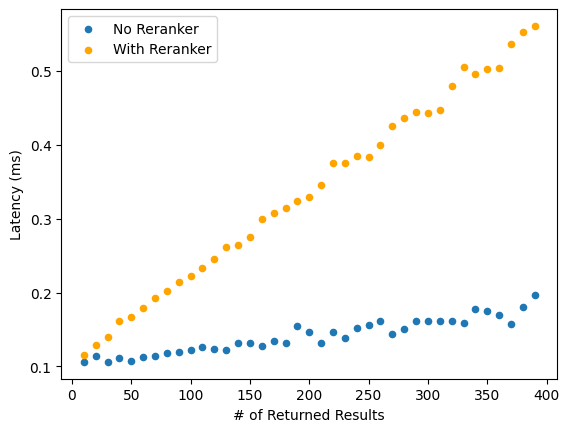

In [65]:
def time_search(limit: int, rerank: bool=True):
    start = time.perf_counter()
    response = client.keyword_search('how do I make a million dollars', 'Impact_theory_minilm_256', limit=limit, display_properties=['content', 'title'], top_k=5, rerank_results=rerank)
    end = time.perf_counter() - start
    return round(end, 3)

false_times = []
for x in tqdm(range(10, 400, 10)):
    false_times.append((time_search(x, rerank=False), x))
    

ranked_times = []
for x in tqdm(range(10, 400, 10)):
    ranked_times.append((time_search(x, rerank=True), x))

import pandas as pd

false_df = pd.DataFrame(false_times, columns=['time', 'n'])
ranked = pd.DataFrame(ranked_times, columns=['time', 'n'])

ax = false_df.plot.scatter(x='n', y='time', label='No Reranker')
ax2 = ranked.plot.scatter(x='n', y='time', ax=ax, color='orange', ylabel='Latency (ms)', label='With Reranker', xlabel='# of Returned Results')